In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_processed_data():
    """
    Load processed data with unique IDs and add derived features.
    Returns:
        tuple: (X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, y_test, test_ids)
    """
    # Load training data
    X_train = pd.read_csv('data/train/features/cluster_features.csv')
    y_train = np.load('data/train/labels/labels.npy')
    train_ids = np.load('data/train/ids/ids.npy')
    
    # Load validation data
    X_val = pd.read_csv('data/val/features/cluster_features.csv')
    y_val = np.load('data/val/labels/labels.npy')
    val_ids = np.load('data/val/ids/ids.npy')
    
    # Load test data
    X_test = pd.read_csv('data/test/features/cluster_features.csv')
    test_ids = np.load('data/test/ids/ids.npy')
    
    # Add derived features to all datasets
    X_train = add_derived_features(X_train)
    X_val = add_derived_features(X_val)
    X_test = add_derived_features(X_test)
    
    # Return the data
    return X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids


def add_derived_features(df):
    """
    Add all derived features to the dataframe.
    """
    df = df.copy()
    
    # Small epsilon to avoid division by zero
    eps = 1e-8
    
    # 1. Ratio-Based Features
    # For pt_fraction_top2, we need to estimate second highest pt
    # Since we have cluster_pt_ratio = max/second_max, we can derive: second_max = max/ratio
    df['second_highest_pt'] = df['max_cluster_pt'] / (df['cluster_pt_ratio'] + eps)
    df['pt_fraction_top2'] = (df['max_cluster_pt'] + df['second_highest_pt']) / (df['total_pt'] + eps)
    
    # Assuming uniform distribution for top 3 (approximation)
    df['pt_fraction_top3'] = df['pt_fraction_top2'] + df['mean_cluster_pt'] / (df['total_pt'] + eps)
    df['pt_fraction_top3'] = df['pt_fraction_top3'].clip(upper=1.0)  # Cap at 1
    
    # Size fractions
    total_size = df['n_clusters'] * df['mean_cluster_size']
    df['size_fraction_largest'] = df['max_cluster_size'] / (total_size + eps)
    
    # Mean to max ratios
    df['mean_to_max_pt_ratio'] = df['mean_cluster_pt'] / (df['max_cluster_pt'] + eps)
    df['mean_to_max_size_ratio'] = df['mean_cluster_size'] / (df['max_cluster_size'] + eps)
    
    # 2. Concentration Metrics
    # For pt concentration, approximate sum of squares
    # Using the fact that Var = E[X²] - E[X]², we get E[X²] = Var + E[X]²
    mean_pt_squared = df['std_cluster_pt']**2 + df['mean_cluster_pt']**2
    sum_pt_squared = mean_pt_squared * df['n_clusters']
    df['pt_concentration'] = df['max_cluster_pt']**2 / (sum_pt_squared + eps)
    
    # Size concentration
    mean_size_squared = df['std_cluster_size']**2 + df['mean_cluster_size']**2
    sum_size_squared = mean_size_squared * df['n_clusters']
    df['size_concentration'] = df['max_cluster_size']**2 / (sum_size_squared + eps)
    
    # Coefficient of variation
    df['cv_cluster_pt'] = df['std_cluster_pt'] / (df['mean_cluster_pt'] + eps)
    df['cv_cluster_size'] = df['std_cluster_size'] / (df['mean_cluster_size'] + eps)
    
    # 3. Asymmetry Features
    df['pt_asymmetry'] = (df['max_cluster_pt'] - df['mean_cluster_pt']) / (df['total_pt'] + eps)
    df['size_asymmetry'] = (df['max_cluster_size'] - df['mean_cluster_size']) / (total_size + eps)
    df['spatial_asymmetry'] = np.abs(df['mean_cluster_eta'] - df['mean_cluster_phi'])
    
    # 4. Normalized Features
    df['normalized_max_pt'] = df['max_cluster_pt'] / (df['total_pt'] + eps)
    df['normalized_std_pt'] = df['std_cluster_pt'] / (df['total_pt'] + eps)
    df['clusters_per_gev'] = df['n_clusters'] / (df['total_pt'] + eps)
    
    # 5. Combined Spatial-Energy Features
    df['eta_weighted_pt'] = df['max_cluster_eta'] * df['max_cluster_pt'] / (df['total_pt'] + eps)
    df['phi_weighted_pt'] = df['max_cluster_phi'] * df['max_cluster_pt'] / (df['total_pt'] + eps)
    df['spatial_extent'] = df['max_cluster_eta'] * df['max_cluster_phi']
    
    # 6. Statistical Moments
    df['pt_skewness'] = (df['max_cluster_pt'] - df['mean_cluster_pt']) / (df['std_cluster_pt'] + eps)
    df['size_skewness'] = (df['max_cluster_size'] - df['mean_cluster_size']) / (df['std_cluster_size'] + eps)
    
    # 7. Logarithmic Features
    df['log_cluster_pt_ratio'] = np.log(df['cluster_pt_ratio'] + 1)  # log(x+1) to handle zeros
    df['log_n_clusters'] = np.log(df['n_clusters'] + 1)
    df['log_total_pt'] = np.log(df['total_pt'] + 1)
    
    # 8. Binary/Categorical Features
    df['is_single_cluster'] = (df['n_clusters'] == 1).astype(int)
    df['has_dominant_cluster'] = (df['cluster_pt_ratio'] > 3).astype(int)
    
    # PT categories (you can adjust thresholds based on your data distribution)
    df['pt_category_low'] = (df['total_pt'] < df['total_pt'].quantile(0.33)).astype(int)
    df['pt_category_high'] = (df['total_pt'] > df['total_pt'].quantile(0.67)).astype(int)
    
    # 9. Interaction Features
    df['pt_size_correlation'] = (df['normalized_max_pt'] * df['size_fraction_largest'])
    df['spatial_spread'] = np.sqrt(df['mean_cluster_eta']**2 + df['mean_cluster_phi']**2)
    df['n_clusters_squared'] = df['n_clusters']**2
    
    # 10. Inverse Features
    df['inv_n_clusters'] = 1 / (df['n_clusters'] + eps)
    df['inv_cluster_pt_ratio'] = 1 / (df['cluster_pt_ratio'] + eps)
    
    # 11. Additional useful features
    df['pt_variance_ratio'] = df['std_cluster_pt']**2 / (df['mean_cluster_pt']**2 + eps)
    df['size_variance_ratio'] = df['std_cluster_size']**2 / (df['mean_cluster_size']**2 + eps)
    
    # Energy balance indicator
    df['energy_balance'] = 1 - df['normalized_max_pt']
    
    # Relative spreads
    df['relative_eta_spread'] = df['max_cluster_eta'] / (df['mean_cluster_eta'] + eps)
    df['relative_phi_spread'] = df['max_cluster_phi'] / (df['mean_cluster_phi'] + eps)
    
    # Drop intermediate columns that were only used for calculations
    df = df.drop(columns=['second_highest_pt'], errors='ignore')
    
    # Handle any potential infinities or NaNs
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    
    return df

In [3]:
# Load data with all the new features automatically added
X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids = load_processed_data()
# Add the label column as before
X_train['type'] = y_train

In [4]:
X_train.head()

,n_clusters,max_cluster_pt,mean_cluster_pt,std_cluster_pt,max_cluster_size,mean_cluster_size,std_cluster_size,total_pt,max_cluster_eta,max_cluster_phi,...,spatial_spread,n_clusters_squared,inv_n_clusters,inv_cluster_pt_ratio,pt_variance_ratio,size_variance_ratio,energy_balance,relative_eta_spread,relative_phi_spread,type
0,13,2.0,0.615318,0.539951,2,2.0,0.0,7.999129,0.5,0.7,...,0.354598,169,0.076923,0.680180,0.770034,0.0,0.749973,6.499999,2.022222,0.0
1,10,2.0,0.777020,0.601157,2,2.0,0.0,7.770204,0.2,0.5,...,0.250799,100,0.100000,0.698917,0.598564,0.0,0.742606,2.000000,2.173913,0.0
2,4,2.0,0.972718,0.606990,2,2.0,0.0,3.890871,0.1,0.1,...,0.070711,16,0.250000,0.390949,0.389394,0.0,0.485976,2.000000,2.000000,0.0
3,14,2.0,0.746367,0.485636,2,2.0,0.0,10.449135,0.5,0.5,...,0.340767,196,0.071429,0.615727,0.423368,0.0,0.808597,2.692308,1.750000,1.0
4,6,2.0,0.575760,0.639069,2,2.0,0.0,3.454561,0.1,0.1,...,0.083333,36,0.166667,0.200473,1.232005,0.0,0.421055,2.000000,1.500000,0.0


In [5]:
print("Dataframe size: ",X_train.shape)
print("Labels size: ",y_train.size)
print("Train IDs size: ",train_ids.size)

Dataframe size:  (3520, 52)
Labels size:  3520
Train IDs size:  3520


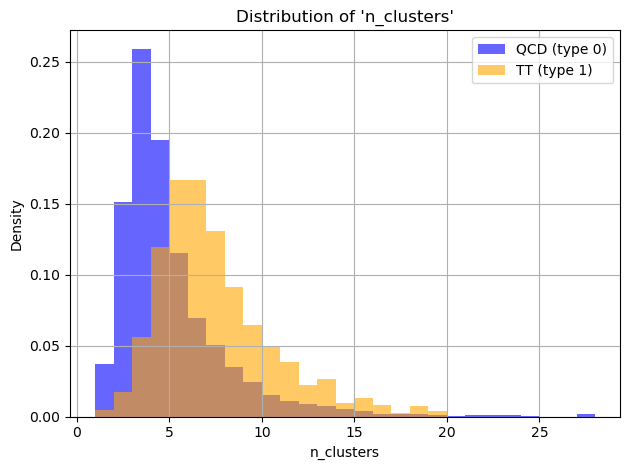

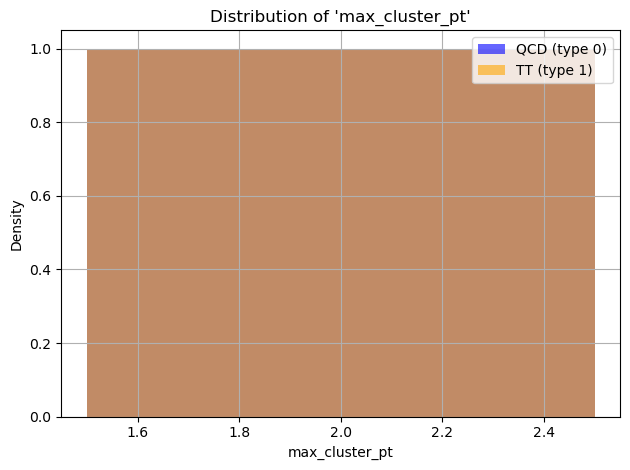

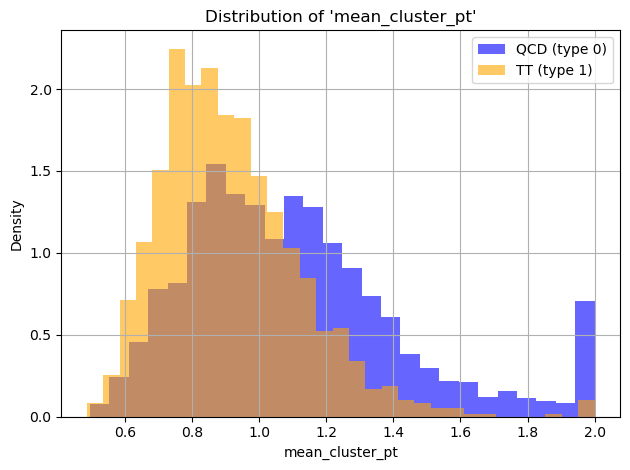

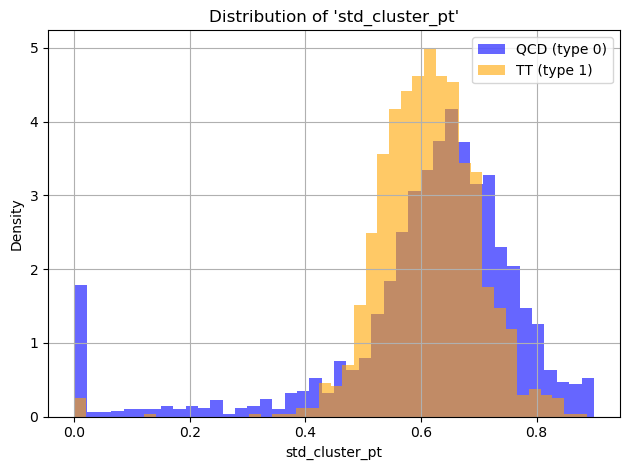

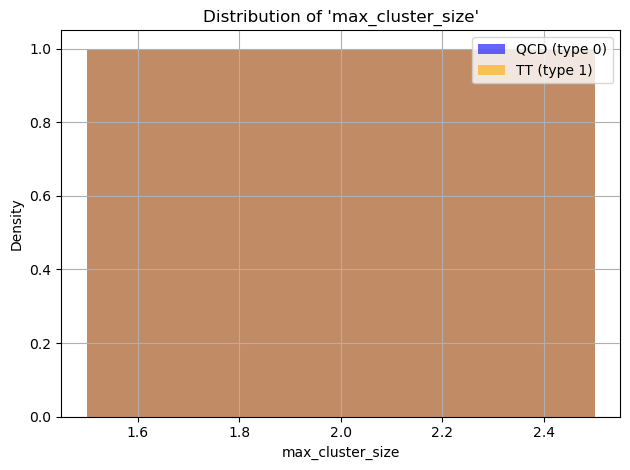

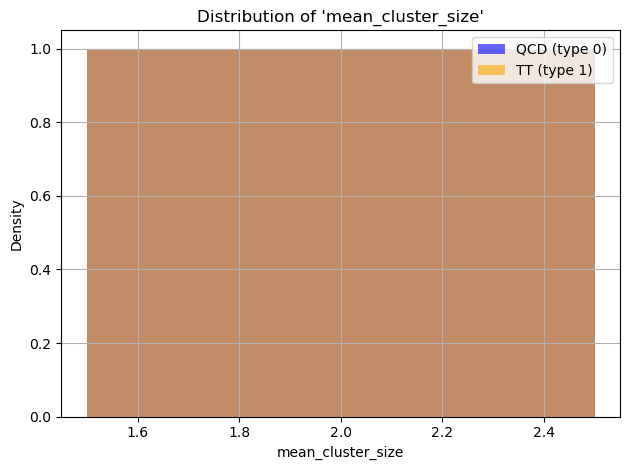

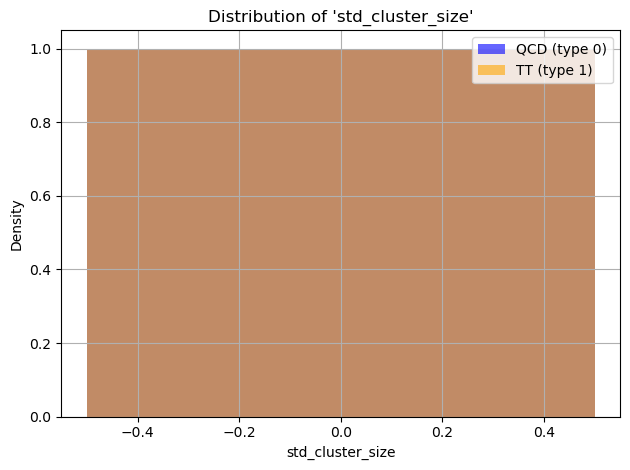

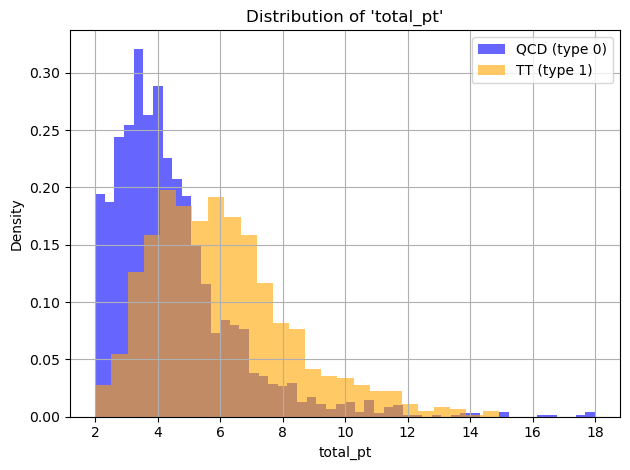

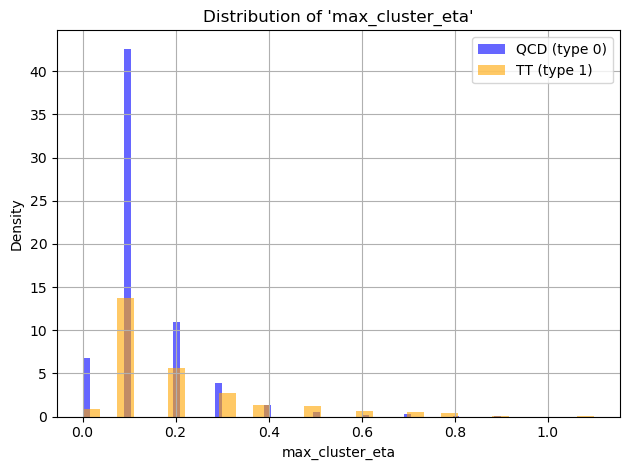

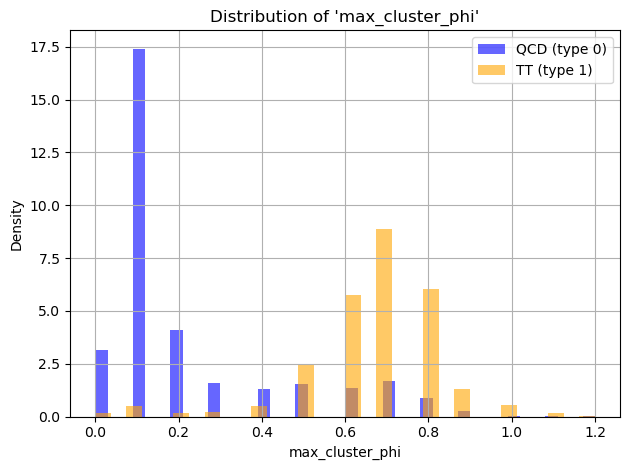

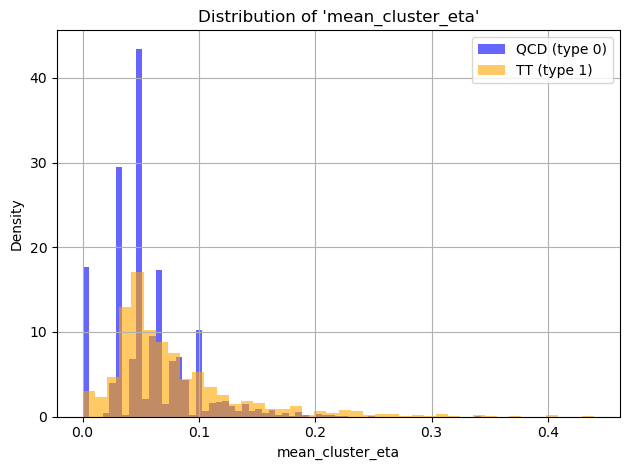

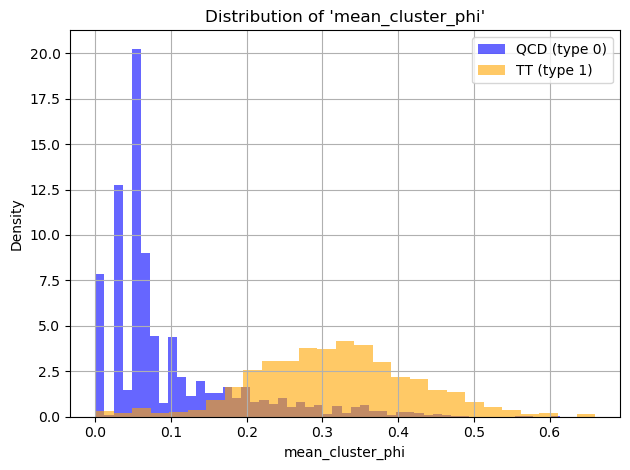

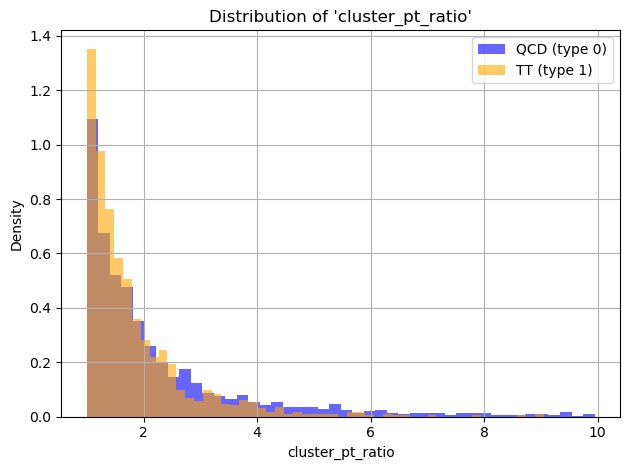

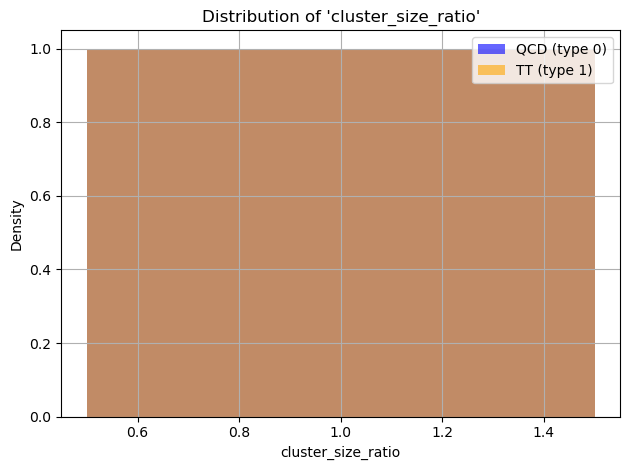

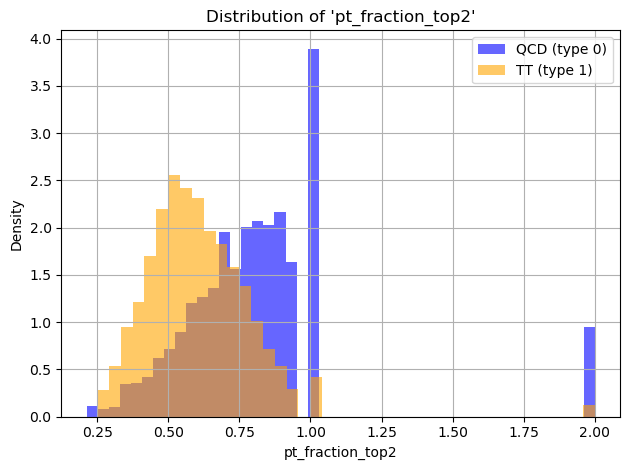

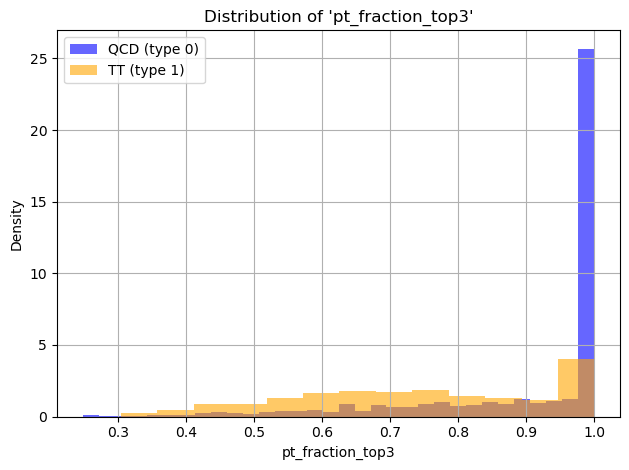

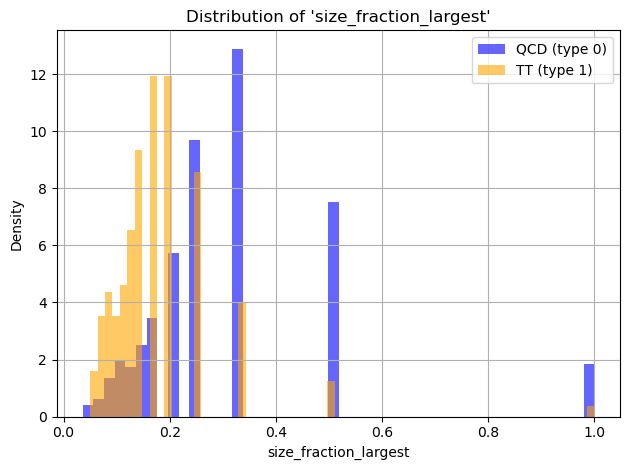

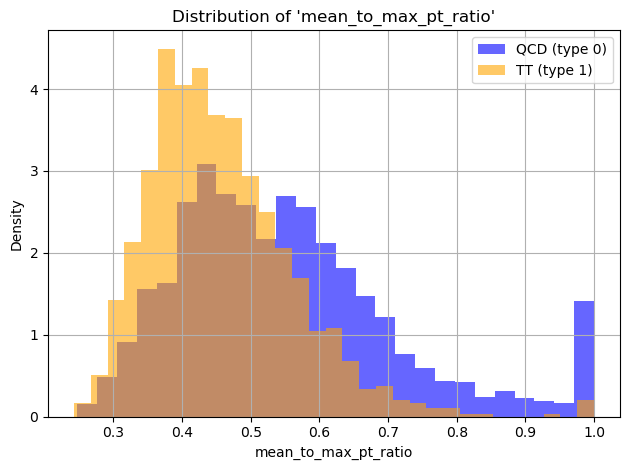

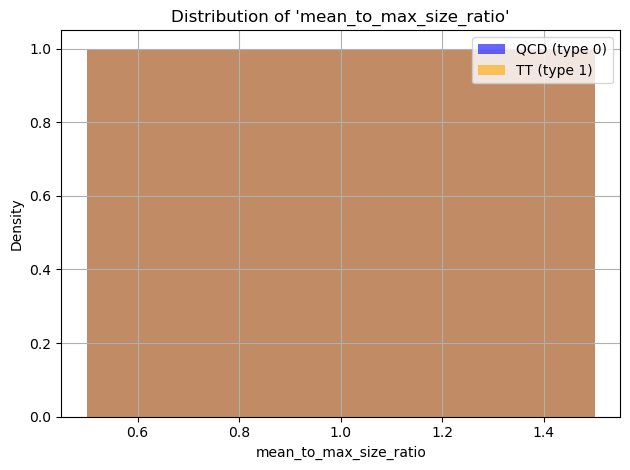

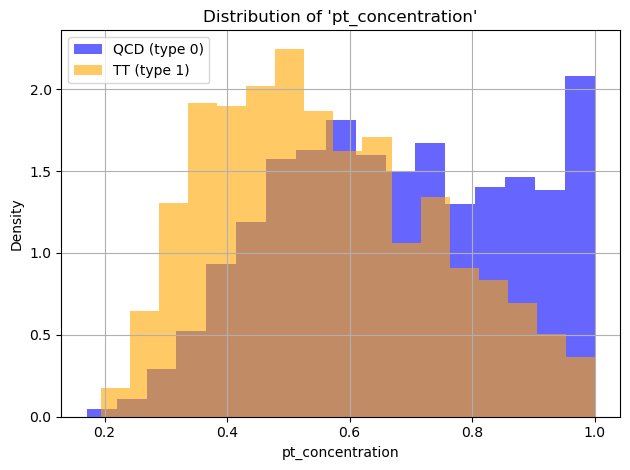

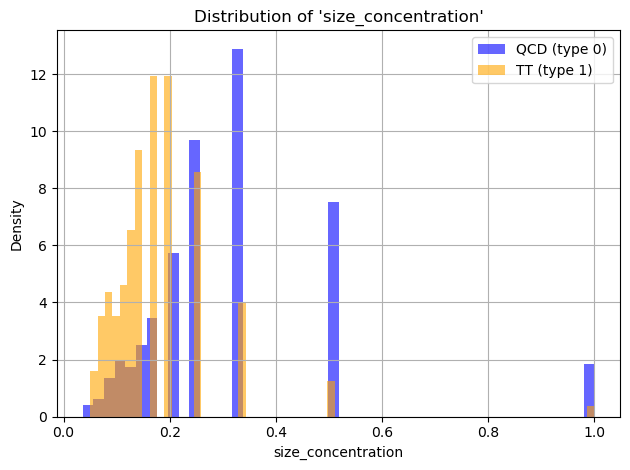

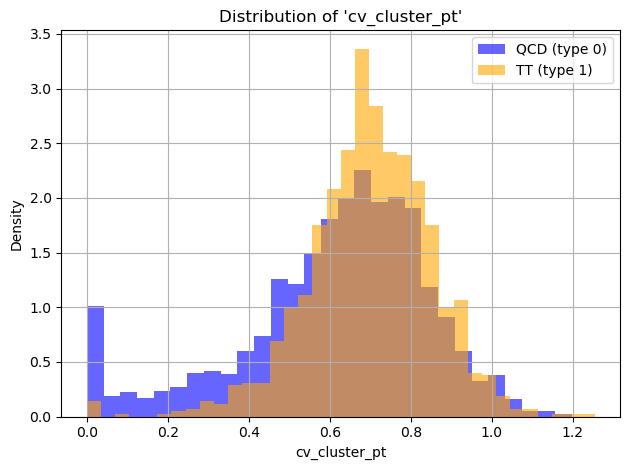

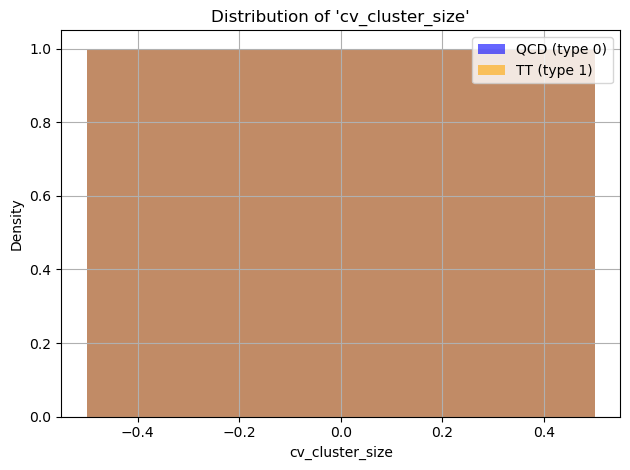

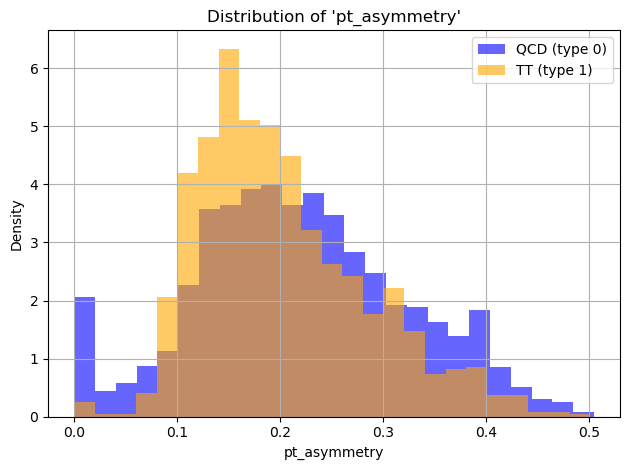

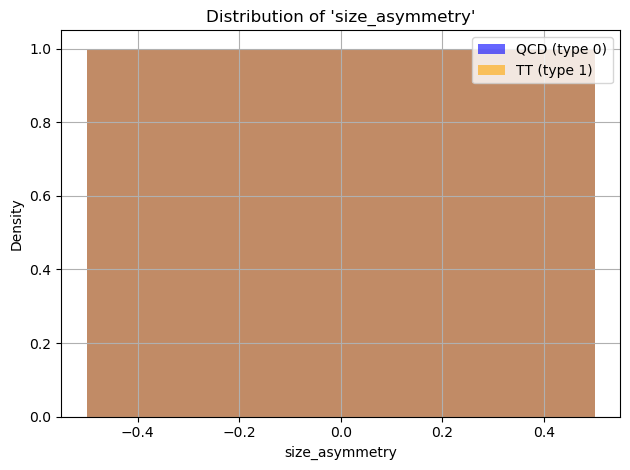

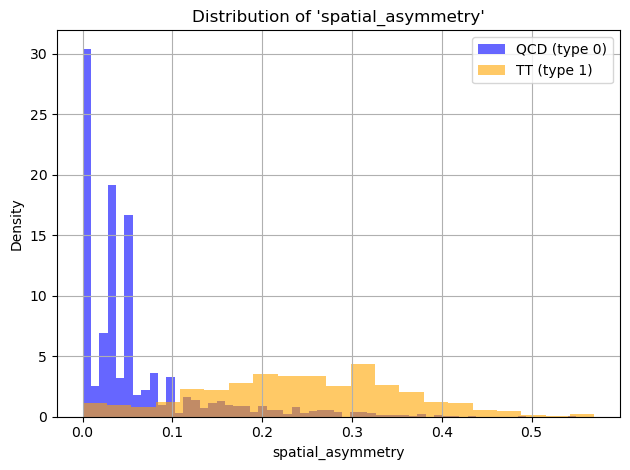

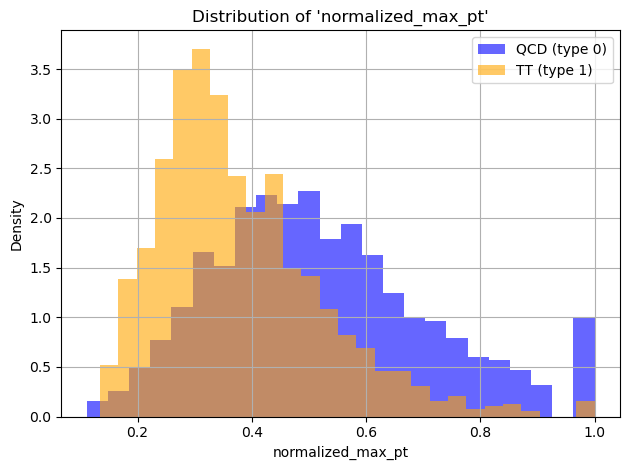

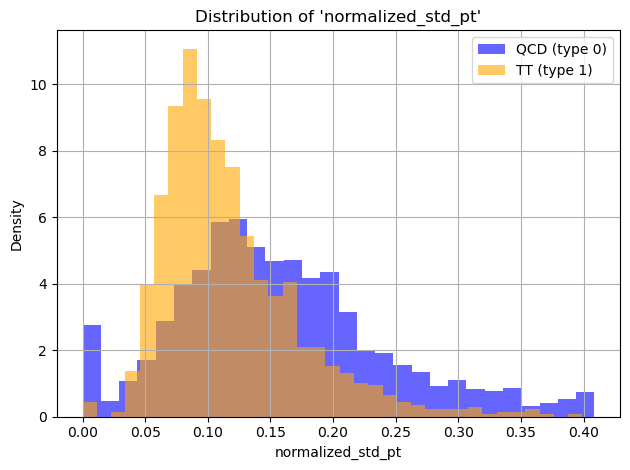

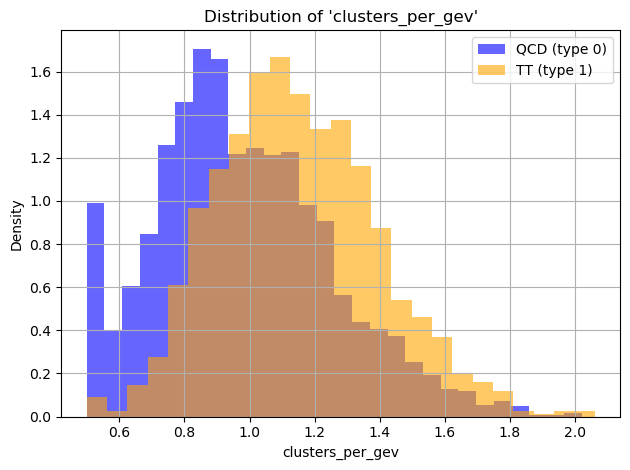

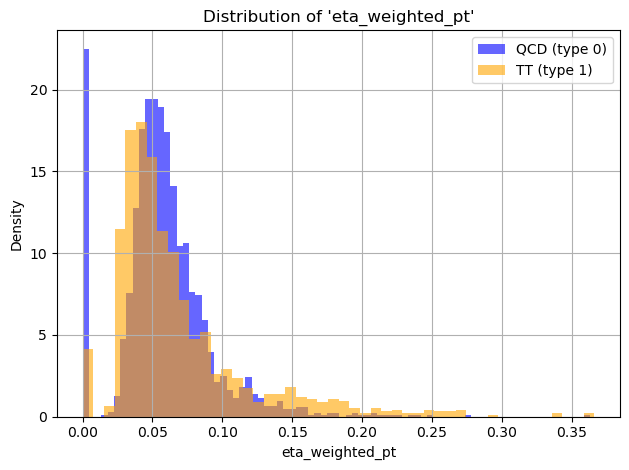

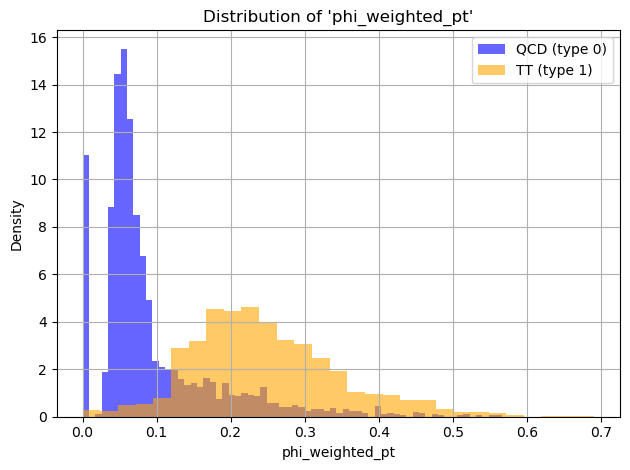

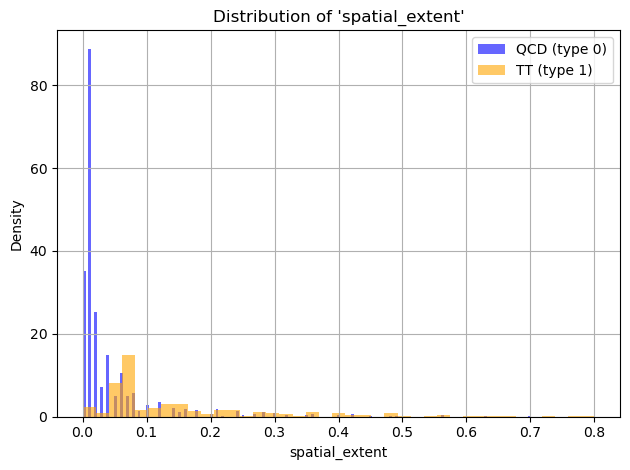

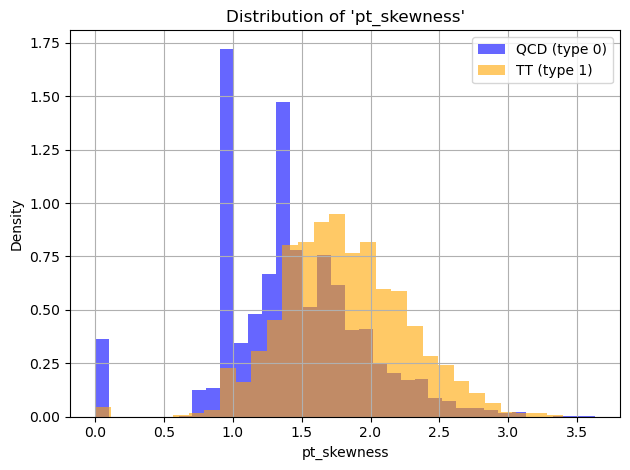

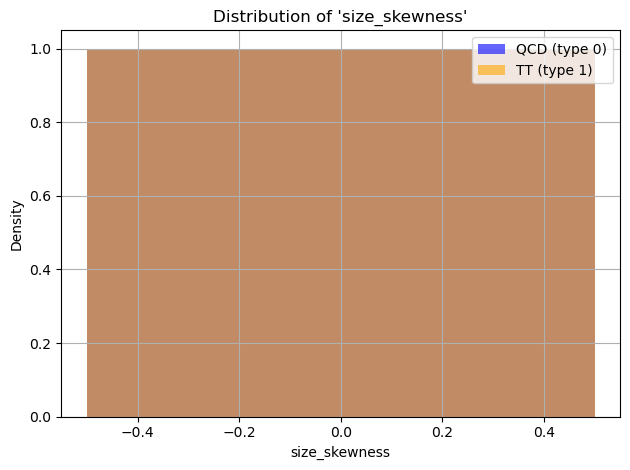

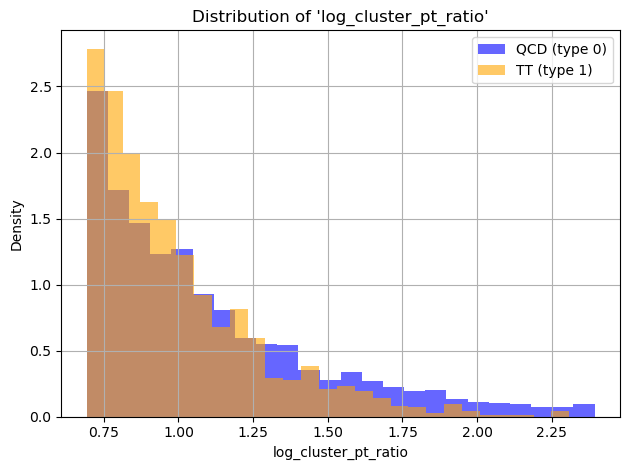

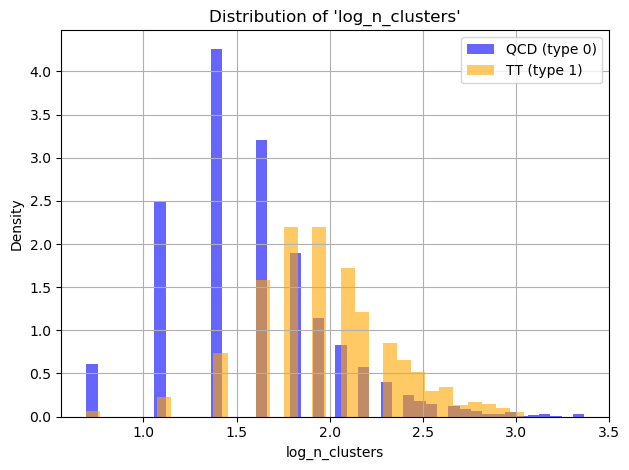

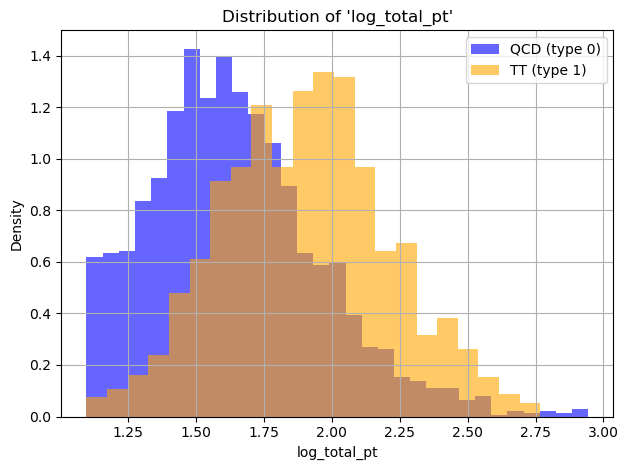

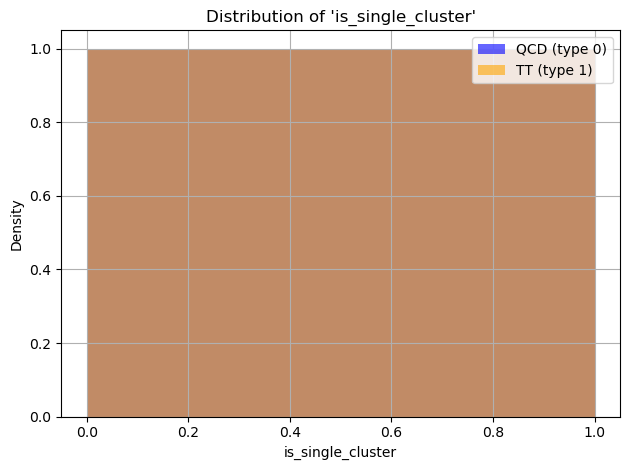

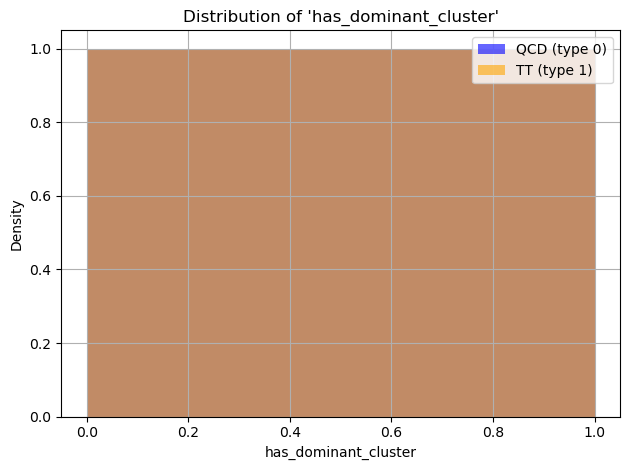

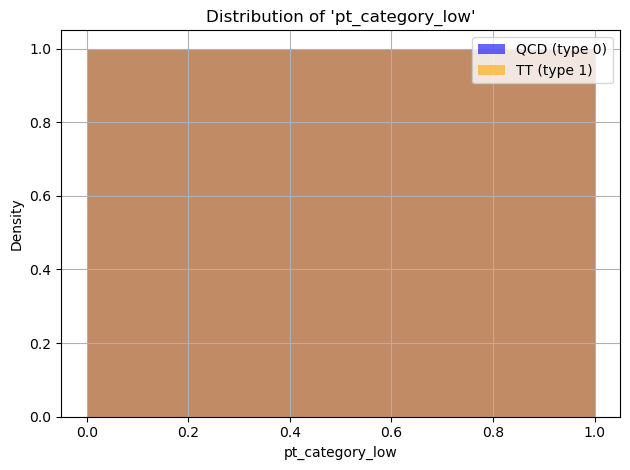

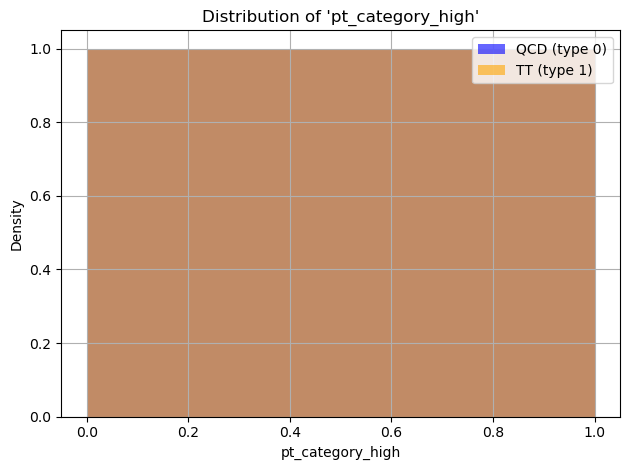

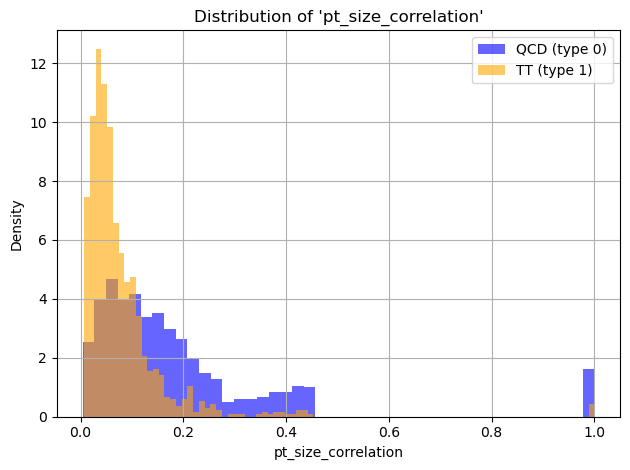

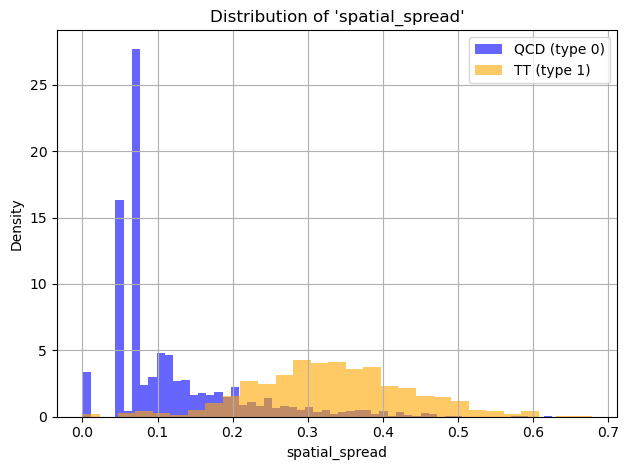

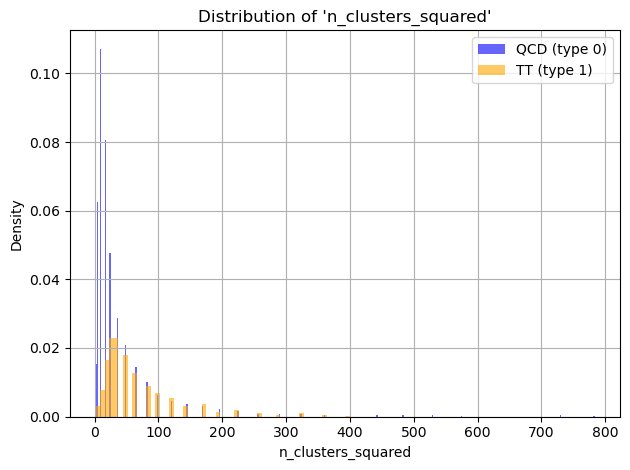

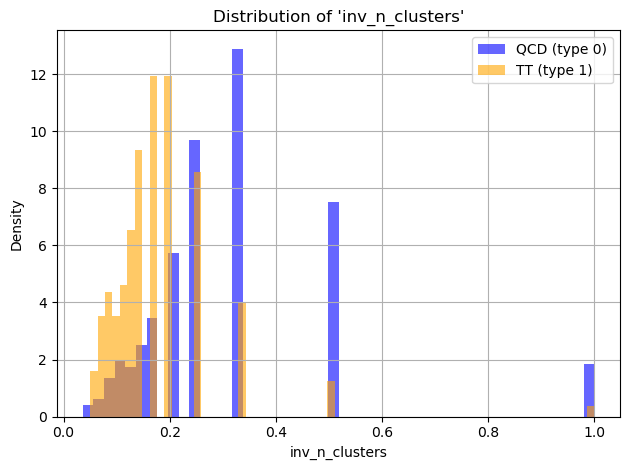

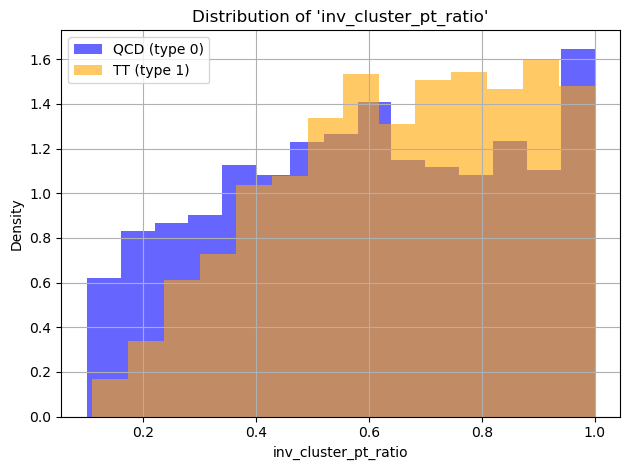

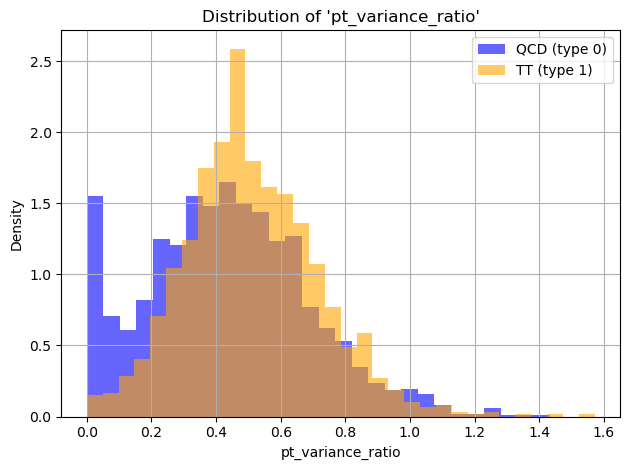

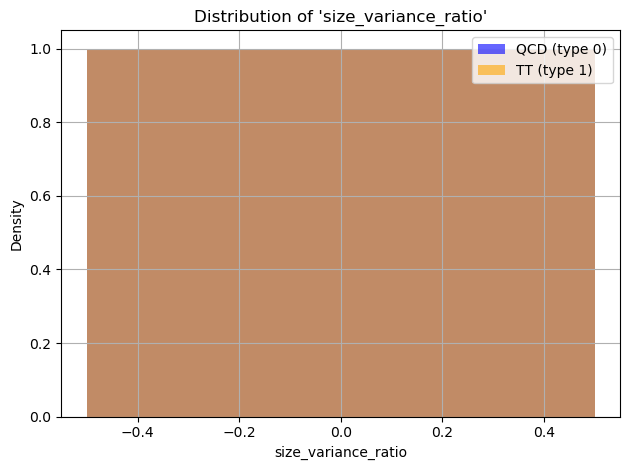

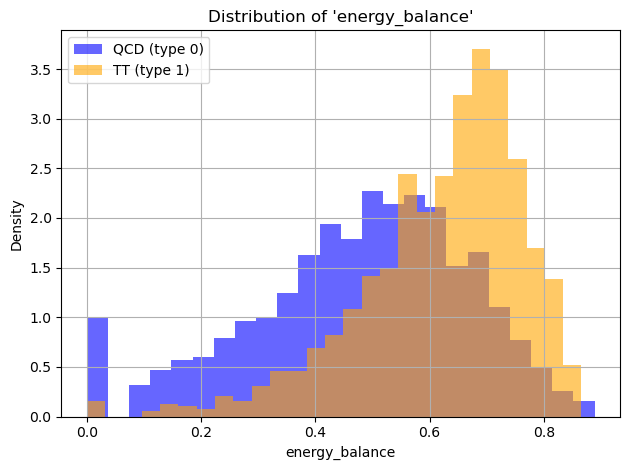

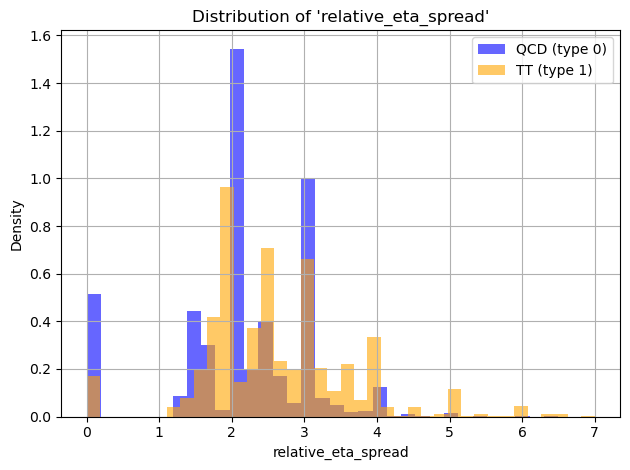

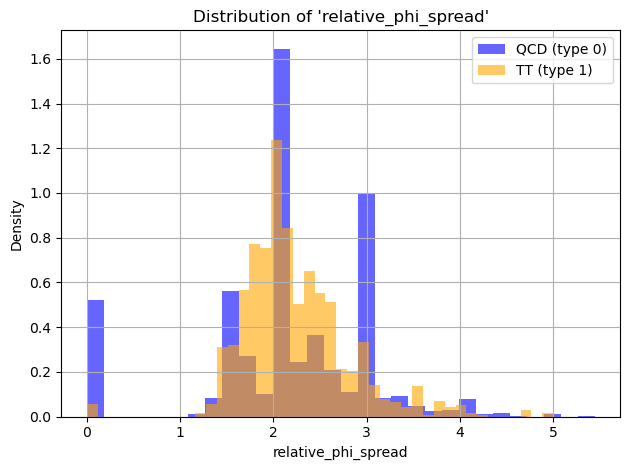

In [6]:
def plot_column(df, column_name):
    '''
    Plots a histogram for both Type 0 (QCD) and Type 1 (TT) for a given column.
    '''
    data_0 = df[df['type'] == 0][column_name]
    data_1 = df[df['type'] == 1][column_name]
    
    plt.hist(data_0, bins='auto', alpha=0.6, label='QCD (type 0)', color='blue', density=True)
    plt.hist(data_1, bins='auto', alpha=0.6, label='TT (type 1)', color='orange', density=True)

    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.title(f"Distribution of '{column_name}'")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all columns
for col in X_train.columns:
    if col != 'type':  # skip the label column if it's in X_train
        plot_column(X_train, col)